In [53]:
use_gpu = False

# EXTERNAL LIBRARY IMPORTS
import numpy as np 
import scipy 
import pandas as pd
import matplotlib.pyplot as plt

import torch # Need torch version >=0.3
import torch.nn as nn 
import torch.optim as optim 
assert float(torch.__version__[:3]) >= 0.3

# MISTER ED SPECIFIC IMPORT BLOCK
# (here we do things so relative imports work )
# Universal import block 
# Block to get the relative imports working 
import os, sys, re, gc, pickle
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import config
import prebuilt_loss_functions as plf
import loss_functions as lf 
import utils.pytorch_utils as utils
import utils.image_utils as img_utils
import cifar10.cifar_loader as cifar_loader
import cifar10.cifar_resnets as cifar_resnets
import adversarial_training as advtrain
import adversarial_evaluation as adveval
import utils.checkpoints as checkpoints
import adversarial_perturbations as ap 
import adversarial_attacks as aa
import spatial_transformers as st

### START pytorch_image_classification imports
import time, random, json, logging, argparse, csv
from pytorch_image_classification_dataloader_c10h import get_loader
from pytorch_image_classification_utils import (str2bool, load_model, save_checkpoint, create_optimizer,
                                                AverageMeter, mixup, CrossEntropyLoss, onehot)
# from rutils_run import save_checkpoint_epoch
from pytorch_image_classification_argparser import get_config

In [30]:
sys.argv = ['']

def parse_args(arch, mdl_config):

    parser = argparse.ArgumentParser()
    # parser.add_argument('--arch', type=str, default='resnet')
    parser.add_argument('--arch', type=str, default=arch)
    # parser.add_argument('--config', type=str, default='tmp_reference_model/resnet_basic_110_config.json')
    parser.add_argument('--config', type=str, default=mdl_config)
    # model config (VGG)
    parser.add_argument('--n_channels', type=str)
    parser.add_argument('--n_layers', type=str)
    parser.add_argument('--use_bn', type=str2bool)
    #
    parser.add_argument('--base_channels', type=int)
    parser.add_argument('--block_type', type=str)
    parser.add_argument('--depth', type=int)
    # model config (ResNet-preact)
    parser.add_argument('--remove_first_relu', type=str2bool)
    parser.add_argument('--add_last_bn', type=str2bool)
    parser.add_argument('--preact_stage', type=str)
    # model config (WRN)
    parser.add_argument('--widening_factor', type=int)
    # model config (DenseNet)
    parser.add_argument('--growth_rate', type=int)
    parser.add_argument('--compression_rate', type=float)
    # model config (WRN, DenseNet)
    parser.add_argument('--drop_rate', type=float)
    # model config (PyramidNet)
    parser.add_argument('--pyramid_alpha', type=int)
    # model config (ResNeXt)
    parser.add_argument('--cardinality', type=int)
    # model config (shake-shake)
    parser.add_argument('--shake_forward', type=str2bool)
    parser.add_argument('--shake_backward', type=str2bool)
    parser.add_argument('--shake_image', type=str2bool)
    # model config (SENet)
    parser.add_argument('--se_reduction', type=int)

    parser.add_argument('--outdir', type=str, required=False)
    parser.add_argument('--seed', type=int, default=17)
    parser.add_argument('--test_first', type=str2bool, default=True)
    parser.add_argument('--gpu', type=str, default='0') # -1 for CPU
    # TensorBoard configuration
    parser.add_argument(
        '--tensorboard', dest='tensorboard', action='store_true', default=True)
    parser.add_argument(
        '--no-tensorboard', dest='tensorboard', action='store_false')
    parser.add_argument('--tensorboard_train_images', action='store_true')
    parser.add_argument('--tensorboard_test_images', action='store_true')
    parser.add_argument('--tensorboard_model_params', action='store_true')
    # configuration of optimizer
    parser.add_argument('--epochs', type=int)
    parser.add_argument('--batch_size', type=int, default=500)
    parser.add_argument('--optimizer', type=str, choices=['sgd', 'adam'])
    parser.add_argument('--base_lr', type=float)
    parser.add_argument('--weight_decay', type=float)
    # configuration for SGD
    parser.add_argument('--momentum', type=float)
    parser.add_argument('--nesterov', type=str2bool)
    # configuration for learning rate scheduler
    parser.add_argument(
        '--scheduler', type=str, choices=['none', 'multistep', 'cosine'])
    # configuration for multi-step scheduler]
    parser.add_argument('--milestones', type=str)
    parser.add_argument('--lr_decay', type=float)
    # configuration for cosine-annealing scheduler]
    parser.add_argument('--lr_min', type=float, default=0)
    # configuration for Adam
    parser.add_argument('--betas', type=str)
    # configuration of data loader
    parser.add_argument(
        '--dataset',
        type=str,
        default='CIFAR10H',
        choices=['CIFAR10', 'CIFAR10H'])
    parser.add_argument('--num_workers', type=int, default=7)
    # cutout configuration
    parser.add_argument('--use_cutout', action='store_true', default=False)
    parser.add_argument('--cutout_size', type=int, default=16)
    parser.add_argument('--cutout_prob', type=float, default=1)
    parser.add_argument('--cutout_inside', action='store_true', default=False)
    # random erasing configuration
    parser.add_argument(
        '--use_random_erasing', action='store_true', default=False)
    parser.add_argument('--random_erasing_prob', type=float, default=0.5)
    parser.add_argument(
        '--random_erasing_area_ratio_range', type=str, default='[0.02, 0.4]')
    parser.add_argument(
        '--random_erasing_min_aspect_ratio', type=float, default=0.3)
    parser.add_argument('--random_erasing_max_attempt', type=int, default=20)
    # mixup configuration
    parser.add_argument('--use_mixup', action='store_true', default=False)
    parser.add_argument('--mixup_alpha', type=float, default=1)

    # previous model weights to load if any
    parser.add_argument('--resume', type=str)
    # whether to tune to human labels
    parser.add_argument('--human_tune', action='store_true', default=False)
    # where to save the loss/accuracy for c10h to a csv file
    parser.add_argument('--c10h_scores_outdir', type=str, default='tmp')
    # c10h scores save interval (in epochs)
    parser.add_argument('--c10h_save_interval', type=str, default='1') # changed from int
    # how much of the data to use use for test for c10h training
    parser.add_argument('--c10h_testsplit_percent', type=float, default=0.1)
    # seed for splitting the c10h data into train/test
    parser.add_argument('--c10h_datasplit_seed', type=int, default=999)
    # whether to use the cifar10 labels for the human test set (CONTROL)
    parser.add_argument('--nonhuman_control', type=str2bool, default=False)
    # whether to sample from the human labels to get one-hot samples
    parser.add_argument('--c10h_sample', action='store_true', default=False)
    # whether to save to out_dir
    parser.add_argument('--no_output', action='store_true', default=False)
    # to test the loaded model and don't train
    parser.add_argument('--test_only', action='store_true', default=False)

    args = parser.parse_args()
    # if not is_tensorboard_available:
    args.tensorboard = False

    config = get_config(args)

    return config

In [31]:
def load_our_model(config, weights_path):
        
    our_model = load_model(config['model_config'])
    
    # load pretrained weights if given
    if os.path.isfile(weights_path):
        print("=> loading checkpoint '{}'".format(weights_path))

        # Resolve CPU/GPU stuff
        if use_gpu:
            map_location = None
        else:
            map_location= (lambda s, l: s)

        checkpoint = torch.load(weights_path,
                                map_location=map_location)

        correct_state_dict = {re.sub(r'^module\.', '', k): v for k, v in
                              checkpoint['state_dict'].items()}

        our_model.load_state_dict(correct_state_dict)

        print("=> loaded checkpoint '{}' (epoch {})"
              .format(weights_path, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(weights_path))
        
    return our_model

# model = load_our_model(config, run_config['resume'])

# cifar_valset = cifar_loader.load_cifar_data('val', batch_size=32)

# _, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=32, use_gpu=use_gpu,
#                                                           return_normalizer=True)
_, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=20,
                                                          return_normalizer=True)
del _

In [107]:
root = '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/'

def get_arch(name):
    if 'vgg_15_BN_64' in name: return 'vgg'
    if 'resnet_basic_110' in name: return 'resnet' 
    if 'resnet_preact_bottleneck_164' in name: return 'resnet_preact' 
    if 'wrn_28_10' in name: return 'wrn' 
    if 'densenet_BC_100_12' in name: return 'densenet' 
    if 'pyramidnet_basic_110_270' in name: return 'pyramidnet' 
    if 'resnext_29_8x64d' in name: return 'resnext' 
    if 'shake_shake_26_2x64d_SSI_cutout16' in name: return 'shake_shake'
    return 'NOT FOUND!!!'

def get_meta(verbose=False, filt=None):
    model_meta = []
    for folder in os.listdir(root):
        if filt: 
            if filt not in folder: break
        param_folders = os.listdir(os.path.join(root, folder))
        for param_folder in param_folders:
            pth_file = os.listdir(os.path.join(root, folder, param_folder))[0]
            meta = {}
            meta['arch'] = get_arch(folder)
            meta['model_name'] = folder
            meta['param_folder'] = param_folder
            meta['pth_file'] = pth_file
            if 'con_True' in param_folder:
                meta['human'] = False
            else:
                meta['human'] = True  

            model_meta.append(meta)
            if verbose: print(meta)
    return model_meta

# model_meta = get_meta(verbose=True, filt='shake_shake')
model_meta = get_meta(verbose=True)

{'arch': 'shake_shake', 'model_name': 'shake_shake_26_2x64d_SSI_cutout16', 'param_folder': 'con_True_lr_0.0001_seed_1', 'pth_file': 'model_best_state_c10h_val_c10_loss.pth', 'human': False}
{'arch': 'shake_shake', 'model_name': 'shake_shake_26_2x64d_SSI_cutout16', 'param_folder': 'con_False_lr_0.01_seed_0', 'pth_file': 'model_best_state_c10h_val_loss.pth', 'human': True}
{'arch': 'resnet_preact', 'model_name': 'resnet_preact_bottleneck_164', 'param_folder': 'con_True_lr_0.001_seed_2', 'pth_file': 'model_best_state_c10h_val_c10_loss.pth', 'human': False}
{'arch': 'resnet_preact', 'model_name': 'resnet_preact_bottleneck_164', 'param_folder': 'con_False_lr_0.1_seed_1', 'pth_file': 'model_best_state_c10h_val_loss.pth', 'human': True}
{'arch': 'resnet', 'model_name': 'resnet_basic_110', 'param_folder': 'con_True_lr_0.01_seed_0', 'pth_file': 'model_best_state_c10h_val_c10_loss.pth', 'human': False}
{'arch': 'resnet', 'model_name': 'resnet_basic_110', 'param_folder': 'con_False_lr_0.01_seed_0

In [56]:
n_batches = 1000 # 1 for test, 1000 for all val data (100-image batches)
save_results = True
break_loop = False

config_folder = '/tigress/ruairidh/model_results/optimal_training_run'

for mm in model_meta:

    cifar_valset = cifar_loader.load_cifar_data('val', batch_size=100)
    
    print(mm['model_name'], mm['human'])
    print('')
    
    config = parse_args(arch=mm['arch'], 
                        mdl_config=os.path.join(config_folder,
                                                mm['model_name'],
                                                'config.json'))
    
    resume_path = os.path.join(root, 
                               mm['model_name'],
                               mm['param_folder'],
                               mm['pth_file'])

    model = load_our_model(config, resume_path)

    # start attacks -----------------------------------------------------
    adv_eval_object = adveval.AdversarialEvaluation(model, normalizer)

    # we'll reuse the loss function:
    attack_loss = plf.VanillaXentropy(model, normalizer)
    linf_8_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                     'lp_bound': 8.0 / 255.0})
    linf_4_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                      'lp_bound': 4.0 / 255.0})


    #------ FGSM8 Block 
    fgsm8_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                     'lp_bound': 8.0/ 255.0})
    fgsm8_attack = aa.FGSM(model, normalizer, linf_8_threat, attack_loss)
    fgsm8_attack_kwargs = {'step_size': 0.05, 
                           'verbose': False}
    fgsm8_attack_params = advtrain.AdversarialAttackParameters(fgsm8_attack,
                                                               attack_specific_params=
                                                               {'attack_kwargs': fgsm8_attack_kwargs})


    # ------ PGD4 Block 
    pgd4_attack = aa.PGD(model, normalizer, linf_4_threat, attack_loss)
    pgd4_attack_kwargs = {'step_size': 1.0 / 255.0, 
                          'num_iterations': 20, 
                          'keep_best': True,
                          'verbose': False}
    pgd4_attack_params = advtrain.AdversarialAttackParameters(pgd4_attack, 
                                                              attack_specific_params=
                                                              {'attack_kwargs': pgd4_attack_kwargs})

    # ------ PGD4 Block 
    pgd8_attack = aa.PGD(model, normalizer, linf_8_threat, attack_loss)
    pgd8_attack_kwargs = {'step_size': 1.0 / 255.0, 
                          'num_iterations': 20, 
                          'keep_best': True,
                          'verbose': False}
    pgd8_attack_params = advtrain.AdversarialAttackParameters(pgd4_attack, 
                                                              attack_specific_params=
                                                              {'attack_kwargs': pgd8_attack_kwargs})





    to_eval_dict = {'top1': 'top1', 
                    'avg_loss_value': 'avg_loss_value', 
                    'avg_successful_ssim': 'avg_successful_ssim'}

    fgsm8_eval = adveval.EvaluationResult(fgsm8_attack_params, 
                                          to_eval=to_eval_dict)


    pgd4_eval = adveval.EvaluationResult(pgd4_attack_params, 
                                         to_eval=to_eval_dict)

    pgd8_eval = adveval.EvaluationResult(pgd8_attack_params, 
                                         to_eval=to_eval_dict)

#     attack_ensemble = {'fgsm8': fgsm8_eval, 
#                        'pgd4' : pgd4_eval, 
#                        'pgd8' : pgd8_eval
#                       }
    attack_ensemble = {'fgsm8': fgsm8_eval}



    ensemble_out = adv_eval_object.evaluate_ensemble(cifar_valset, attack_ensemble, 
                                                     verbose=False, 
                                                     num_minibatches=n_batches)



    sort_order = {'ground': 1, 'fgsm8': 2, 'pgd4': 3, 'pgd8': 4}
    def pretty_printer(eval_ensemble, result_type):
        print('~' * 10, result_type, '~' * 10)
        for key in sorted(list(eval_ensemble.keys()), key=lambda k: sort_order[k]):
            eval_result = eval_ensemble[key]
            pad = 6 - len(key)
            if result_type not in eval_result.results:
                continue 
            avg_result = eval_result.results[result_type].avg
            print(key, pad* ' ', ': ', avg_result)

    print('')
    pretty_printer(ensemble_out, 'top1')
    pretty_printer(ensemble_out, 'avg_loss_value')
    pretty_printer(ensemble_out, 'avg_successful_ssim')
    print('')
    print('')
    print('')
    
    for ae_key in attack_ensemble.keys():
        for e_key in to_eval_dict.keys():
            try:
                mm[ae_key][e_key] = ensemble_out[ae_key].results[e_key].avg
            except:
                try:
                    mm[ae_key] = {e_key: ensemble_out[ae_key].results[e_key].avg}
                except:
                    pass
    print(mm)
    
    del model
    gc.collect()
    if break_loop: break
    if save_results: 
        pickle.dump(model_meta, open('fgsm_results.pickle','wb'))

Files already downloaded and verified
shake_shake_26_2x64d_SSI_cutout16 False

=> loading checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/shake_shake_26_2x64d_SSI_cutout16/con_True_lr_0.0001_seed_1/model_best_state_c10h_val_c10_loss.pth'
=> loaded checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/shake_shake_26_2x64d_SSI_cutout16/con_True_lr_0.0001_seed_1/model_best_state_c10h_val_c10_loss.pth' (epoch 123)


/home/joshuacp/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]



~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  0.9875
fgsm8   :  0.3945
~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
fgsm8   :  4.030575957298279
~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
fgsm8   :  0.0434574058042086



{'arch': 'shake_shake', 'model_name': 'shake_shake_26_2x64d_SSI_cutout16', 'param_folder': 'con_True_lr_0.0001_seed_1', 'pth_file': 'model_best_state_c10h_val_c10_loss.pth', 'human': False, 'fgsm8': {'top1': 0.3945, 'avg_loss_value': 4.030575957298279, 'avg_successful_ssim': 0.0434574058042086}, 'ground': {'top1': 0.9875}}
Files already downloaded and verified
shake_shake_26_2x64d_SSI_cutout16 True

=> loading checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/shake_shake_26_2x64d_SSI_cutout16/con_False_lr_0.01_seed_0/model_best_state_c10h_val_loss.pth'
=> loaded checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/shake_shake_26_2x64d_SSI_cutout16/con_False_lr_0.01_seed_0/model_best_state_c10h_val_loss.pth' (epoch 69)

~~~

=> loaded checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/vgg_15_BN_64/con_False_lr_0.01_seed_0/model_best_state_c10h_val_loss.pth' (epoch 86)

~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  0.9792
fgsm8   :  0.0806
~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
fgsm8   :  4.08302312374115
~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
fgsm8   :  0.043275029180260216



{'arch': 'vgg', 'model_name': 'vgg_15_BN_64', 'param_folder': 'con_False_lr_0.01_seed_0', 'pth_file': 'model_best_state_c10h_val_loss.pth', 'human': True, 'fgsm8': {'top1': 0.0806, 'avg_loss_value': 4.08302312374115, 'avg_successful_ssim': 0.043275029180260216}, 'ground': {'top1': 0.9792}}
Files already downloaded and verified
resnext_29_8x64d True

=> loading checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/resnext_29_8x64d/con_False_lr_0.001_seed_0/model_best_state_c10h_val_loss.pth'
=> loaded checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_control

In [87]:
ensemble_out['fgsm8'].results['avg_loss_value'].avg

2.7959851121902464

In [82]:
_ = [mm for mm in model_meta if mm['arch']=='shake_shake']
_

[{'arch': 'shake_shake',
  'model_name': 'shake_shake_26_2x64d_SSI_cutout16',
  'param_folder': 'con_True_lr_0.0001_seed_1',
  'pth_file': 'model_best_state_c10h_val_c10_loss.pth',
  'human': False,
  'fgsm8': {'top1': 0.3945,
   'avg_loss_value': 4.030575957298279,
   'avg_successful_ssim': 0.0434574058042086},
  'ground': {'top1': 0.9875}},
 {'arch': 'shake_shake',
  'model_name': 'shake_shake_26_2x64d_SSI_cutout16',
  'param_folder': 'con_False_lr_0.01_seed_0',
  'pth_file': 'model_best_state_c10h_val_loss.pth',
  'human': True,
  'fgsm8': {'top1': 0.3854,
   'avg_loss_value': 2.091712098121643,
   'avg_successful_ssim': 0.043293468786753636},
  'ground': {'top1': 0.989}}]

In [ ]:
# PGM ATTACKS ONLY!!!

# model_meta = get_meta(filt='shake_shake')
model_meta = get_meta()

n_batches = 50
save_results = True
break_loop = False

config_folder = '/tigress/ruairidh/model_results/optimal_training_run'

for mm in model_meta:
    
    print(mm['model_name'], mm['human'])
    print('')
    
    config = parse_args(arch=mm['arch'], 
                        mdl_config=os.path.join(config_folder,
                                                mm['model_name'],
                                                'config.json'))
    
    resume_path = os.path.join(root, 
                               mm['model_name'],
                               mm['param_folder'],
                               mm['pth_file'])

    model = load_our_model(config, resume_path)
    
    for n_updates in range(10):
        print('PGD GRAD UPDATE', n_updates+1)
        cifar_valset = cifar_loader.load_cifar_data('val', batch_size=2)

        # start attacks -----------------------------------------------------
        adv_eval_object = adveval.AdversarialEvaluation(model, normalizer)

        # we'll reuse the loss function:
        attack_loss = plf.VanillaXentropy(model, normalizer)
        linf_8_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                         'lp_bound': 8.0 / 255.0})
        linf_4_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                          'lp_bound': 4.0 / 255.0})


        #------ FGSM8 Block 
        fgsm8_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                         'lp_bound': 8.0/ 255.0})
        fgsm8_attack = aa.FGSM(model, normalizer, linf_8_threat, attack_loss)
        fgsm8_attack_kwargs = {'step_size': 0.05, 
                               'verbose': False}
        fgsm8_attack_params = advtrain.AdversarialAttackParameters(fgsm8_attack,
                                                                   attack_specific_params=
                                                                   {'attack_kwargs': fgsm8_attack_kwargs})


        # ------ PGD4 Block 
        pgd4_attack = aa.PGD(model, normalizer, linf_4_threat, attack_loss)
        pgd4_attack_kwargs = {'step_size': 1.0 / 255.0, 
                              'num_iterations': n_updates, 
                              'keep_best': True,
                              'verbose': False}
        pgd4_attack_params = advtrain.AdversarialAttackParameters(pgd4_attack, 
                                                                  attack_specific_params=
                                                                  {'attack_kwargs': pgd4_attack_kwargs})

        # ------ PGD4 Block 
        pgd8_attack = aa.PGD(model, normalizer, linf_8_threat, attack_loss)
        pgd8_attack_kwargs = {'step_size': 1.0 / 255.0, 
                              'num_iterations': n_updates, 
                              'keep_best': True,
                              'verbose': False}
        pgd8_attack_params = advtrain.AdversarialAttackParameters(pgd4_attack, 
                                                                  attack_specific_params=
                                                                  {'attack_kwargs': pgd8_attack_kwargs})





        to_eval_dict = {'top1': 'top1', 
                        'avg_loss_value': 'avg_loss_value', 
                        'avg_successful_ssim': 'avg_successful_ssim'}

        fgsm8_eval = adveval.EvaluationResult(fgsm8_attack_params, 
                                              to_eval=to_eval_dict)


        pgd4_eval = adveval.EvaluationResult(pgd4_attack_params, 
                                             to_eval=to_eval_dict)

        pgd8_eval = adveval.EvaluationResult(pgd8_attack_params, 
                                             to_eval=to_eval_dict)

        attack_ensemble = {
                           'pgd4' : pgd4_eval, 
#                            'pgd8' : pgd8_eval
                          }



        ensemble_out = adv_eval_object.evaluate_ensemble(cifar_valset, attack_ensemble, 
                                                         verbose=False, 
                                                         num_minibatches=n_batches)



        sort_order = {'ground': 1, 'fgsm8': 2, 'pgd4': 3, 'pgd8': 4}
        def pretty_printer(eval_ensemble, result_type):
            print('~' * 10, result_type, '~' * 10)
            for key in sorted(list(eval_ensemble.keys()), key=lambda k: sort_order[k]):
                eval_result = eval_ensemble[key]
                pad = 6 - len(key)
                if result_type not in eval_result.results:
                    continue 
                avg_result = eval_result.results[result_type].avg
                print(key, pad* ' ', ': ', avg_result)

        print('')
        pretty_printer(ensemble_out, 'top1')
        pretty_printer(ensemble_out, 'avg_loss_value')
        pretty_printer(ensemble_out, 'avg_successful_ssim')
        print('')
        print('')
        print('')

        for ae_key in attack_ensemble.keys():
            if ae_key not in mm.keys():
                mm[ae_key] = {}
            for e_key in to_eval_dict.keys():
                if e_key not in mm[ae_key].keys() and (e_key in ensemble_out[ae_key].results.keys()):
                    mm[ae_key][e_key] = []
                try:
                    mm[ae_key][e_key].append(ensemble_out[ae_key].results[e_key].avg)
                except:
                    pass
#         print(mm)

#         del model
        gc.collect()
        if break_loop: break
        if save_results: 
            pickle.dump(model_meta, open('pgd_results.pickle','wb'))
    print(mm)
    if break_loop: break

shake_shake_26_2x64d_SSI_cutout16 False

=> loading checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/shake_shake_26_2x64d_SSI_cutout16/con_True_lr_0.0001_seed_1/model_best_state_c10h_val_c10_loss.pth'
=> loaded checkpoint '/tigress/joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/shake_shake_26_2x64d_SSI_cutout16/con_True_lr_0.0001_seed_1/model_best_state_c10h_val_c10_loss.pth' (epoch 123)
PGD GRAD UPDATE 1
Files already downloaded and verified

~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  0.98
pgd4    :  0.98
~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
pgd4    :  0.03144082546234131
~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
pgd4    :  0



PGD GRAD UPDATE 2
Files already downloaded and verified


/home/joshuacp/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]



~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  1.0
pgd4    :  0.7
~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
pgd4    :  1.427823805809021
~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
pgd4    :  0.000668124217690765



PGD GRAD UPDATE 3
Files already downloaded and verified

~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  0.97
pgd4    :  0.32
~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
pgd4    :  5.750855340957641
~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
pgd4    :  0.0017781359293342818



PGD GRAD UPDATE 4
Files already downloaded and verified

~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  1.0
pgd4    :  0.14
~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
pgd4    :  10.125313777923584
~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
pgd4    :  0.003198474210366652



PGD GRAD UPDATE 5
Files already downloaded and verified

~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  0.99
pgd4    :  0.03
~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
pgd4    :  14.931519737243653
~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
pgd4    :  0.004635109303991808



PGD GRAD UPDATE 6
Fi

In [150]:
df_plot_all = pd.DataFrame(model_meta)
df_plot_all

,arch,ground,human,model_name,param_folder,pgd4,pth_file
0,shake_shake,"{'top1': [0.98, 0.99, 0.99, 1.0, 0.98, 1.0, 1....",False,shake_shake_26_2x64d_SSI_cutout16,con_True_lr_0.0001_seed_1,"{'top1': [0.98, 0.69, 0.32, 0.12, 0.03, 0.03, ...",model_best_state_c10h_val_c10_loss.pth
1,shake_shake,"{'top1': [0.98, 1.0, 0.97, 0.97, 0.98, 1.0, 0....",True,shake_shake_26_2x64d_SSI_cutout16,con_False_lr_0.01_seed_0,"{'top1': [0.98, 0.86, 0.53, 0.22, 0.1, 0.05, 0...",model_best_state_c10h_val_loss.pth


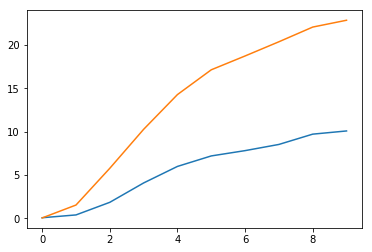

In [151]:
for mn in df_plot_all.model_name.unique():
    
    df_plot = df_plot_all[df_plot_all.model_name==mn].copy()
    
    y = df_plot[df_plot.human==True]['pgd4'].values[0]['avg_loss_value']
    x = np.arange(len(y))
    plt.plot(x, y)

    y = df_plot[df_plot.human==False]['pgd4'].values[0]['avg_loss_value']
    x = np.arange(len(y))
    plt.plot(x, y)

In this file we'll be looking at the techniques we'll use to evaluate both attacks and defenses. In general, the task we want to solve is this: we have a classifier trained on a dataset and wish to evaluate its accuracy against unperturbed inputs as well as various properties of an adversarial attack that has gradient access to this classifier. 

Recall that an adversarial attack here has many degrees of freedom we can choose:
- Threat model: $\ell_p$-bounded noise, rotations, translations, flow, any combination of the above
- Bounds for the threat model
- Attack technique: PGD, FGSM, Carlini-Wagner
- Attack parameters: number of iterations, step size, loss functions, etc

And we can choose to evaluate several properties of each attack on a network: 
- Top-k accuracy 
- Average successful loss value 
- The generated adversarial images 
- Average distance (say according to a custom function) of generated adversarial images to their originals

All we'll be doing in this file is walking through an example of how to build objects to perform evaluations of (some of) these properties on a medley of attacks. 


## Building an AdversarialEvaluationObject

In [21]:
%%html
<img src="images/adversarial_evaluation.png",width=60,height=60>

The above image describes the general workflow: 
First we initialize an `AdversarialEvaluation` instance which keeps track of which classifier we're evaluating against, as well as the normalizer (which recall just performs some operations on raw-data to make it classifier-friendly). This instance will have an `evaluate_ensemble` method which needs as arguments a DataLoader and a dictionary, called the `attack_ensemble`, that contains the attacks (which are wrapped up in `EvaluationResult` instances). This method will output a dictionary that points to the same `EvaluationResult` objects which now have the result data stored in them. Unless otherwise specified, we'll also evaluate the ground accuracy of the classifier and include that in the return-value as well.


Let's go ahead and build up everything except the `EvaluationResult` objects and proceed from there.


In [42]:
# Load the trained model and normalizer
# model, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=20, return_normalizer=True) 

# Load the evaluation dataset 
cifar_valset = cifar_loader.load_cifar_data('val') 

# Put this into the AdversarialEvaluation object
adv_eval_object = adveval.AdversarialEvaluation(model, normalizer)

Files already downloaded and verified


## Building an Attack Ensemble

Recall in tutorial_1 we built `AdversarialAttack` objects and used their `.attack(...)` methods to generate adversarial perturbations, where the keyword arguments to `.attack(...)` described the parameters of the attack.

And then in tutorial_2 we build `AdversarialAttackParameters` objects which is a wrapper to hold an `AdversarialAttack` object and the kwargs that described the parameters of the attack. We used this to generate attacks inside the training loop to perform adversarial training.

And finally, in this tutorial we'll build `EvaluationResult` objects which hold an `AdversarialAttackParameters` object and a dictionary storing some information about what we'll evaluate.

The following image summarizes the data structures we've built (the bullet points refer to the arguments needed upon construction)

In [10]:
%%html 
<img src="images/evaluationResult_ds.png",width=60,height=60>

In this worked example, we'll build 3 different evaluation results and evaluate them simultaneously:
- **FGSM8**: An additive noise attack, with $\ell_\infty$ bound of 8.0, attacked using FGSM 
- **PGD4**: An additive noise attack, with $\ell_\infty$ bound of 4.0, attacked using PGD 
- **PGD8**: An additive noise attack, with $\ell_\infty$ bound of 8.0, attacked using PGD

In [43]:
# First let's build the attack parameters for each.
# Note: we're not doing anything new yet. These constructions are covered in the first two tutorials

# we'll reuse the loss function:
attack_loss = plf.VanillaXentropy(model, normalizer)
linf_8_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                 'lp_bound': 8.0 / 255.0})
linf_4_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                  'lp_bound': 4.0 / 255.0})


#------ FGSM8 Block 
fgsm8_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                 'lp_bound': 8.0/ 255.0})
fgsm8_attack = aa.FGSM(model, normalizer, linf_8_threat, attack_loss)
fgsm8_attack_kwargs = {'step_size': 0.05, 
                       'verbose': False}
fgsm8_attack_params = advtrain.AdversarialAttackParameters(fgsm8_attack,
                                                           attack_specific_params=
                                                           {'attack_kwargs': fgsm8_attack_kwargs})


# ------ PGD4 Block 
pgd4_attack = aa.PGD(model, normalizer, linf_4_threat, attack_loss)
pgd4_attack_kwargs = {'step_size': 1.0 / 255.0, 
                      'num_iterations': 20, 
                      'keep_best': True,
                      'verbose': False}
pgd4_attack_params = advtrain.AdversarialAttackParameters(pgd4_attack, 
                                                          attack_specific_params=
                                                          {'attack_kwargs': pgd4_attack_kwargs})

# ------ PGD4 Block 
pgd8_attack = aa.PGD(model, normalizer, linf_8_threat, attack_loss)
pgd8_attack_kwargs = {'step_size': 1.0 / 255.0, 
                      'num_iterations': 20, 
                      'keep_best': True,
                      'verbose': False}
pgd8_attack_params = advtrain.AdversarialAttackParameters(pgd4_attack, 
                                                          attack_specific_params=
                                                          {'attack_kwargs': pgd8_attack_kwargs})

In [44]:
'''
Next we'll build the EvaluationResult objects that wrap these. 
And let's say we'll evaluate the:
- top1 accuracy 
- average loss 
- average SSIM distance of successful perturbations [don't worry too much about this]

The 'to_eval' dict as passed in the constructor has structure 
 {key : <shorthand fxn>}
where key is just a human-readable handle for what's being evaluated
and shorthand_fxn is either a string for prebuilt evaluators, or you can pass in a general function to evaluate
'''

to_eval_dict = {'top1': 'top1', 
                'avg_loss_value': 'avg_loss_value', 
                'avg_successful_ssim': 'avg_successful_ssim'}

fgsm8_eval = adveval.EvaluationResult(fgsm8_attack_params, 
                                      to_eval=to_eval_dict)


pgd4_eval = adveval.EvaluationResult(pgd4_attack_params, 
                                     to_eval=to_eval_dict)

pgd8_eval = adveval.EvaluationResult(pgd8_attack_params, 
                                     to_eval=to_eval_dict)



With our `EvaluationResult` objects built, all that remains is to collect all these into a dictionary and pass them to our `AdversarialEvaluation` object and interpret the result.

In [45]:
attack_ensemble = {'fgsm8': fgsm8_eval, 
                   'pgd4' : pgd4_eval, 
                   'pgd8' : pgd8_eval
                  }
ensemble_out = adv_eval_object.evaluate_ensemble(cifar_valset, attack_ensemble, 
                                                 verbose=True, 
                                                 num_minibatches=1)


Starting minibatch 0...
	 (mb: 0) evaluating fgsm8...


/home/joshuacp/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


	 (mb: 0) evaluating pgd4...
	 (mb: 0) evaluating pgd8...
	 (mb: 0) evaluating ground...


Now let's take a look at the evaluation results. First notice that the key `'ground'` has been added to the ensemble output. This stores the top1 accuracy of unperturbed inputs (and thus the accuracy of the classifier).

In general, the results of the evaluations will be stored in the `EvaluationResult.results` dictionary, with the keys being the same as the evaluation types desired. These generally will point to an `AverageMeter` object, which is a simple little object to keep track of average values. You can query its `.avg` value:

In [46]:
# First notice the keys of ensemble_out include ground:
print(attack_ensemble.keys())

attack_ensemble['pgd8'].results

dict_keys(['fgsm8', 'pgd4', 'pgd8', 'ground'])


{'top1': <utils.pytorch_utils.AverageMeter at 0x7fe8d4075160>,
 'avg_loss_value': <utils.pytorch_utils.AverageMeter at 0x7fe8d40750f0>,
 'avg_successful_ssim': <utils.pytorch_utils.AverageMeter at 0x7fe8d4075208>}

In [47]:
# Now let's build a little helper to print things out cleanly:

sort_order = {'ground': 1, 'fgsm8': 2, 'pgd4': 3, 'pgd8': 4}
def pretty_printer(eval_ensemble, result_type):
    print('~' * 10, result_type, '~' * 10)
    for key in sorted(list(eval_ensemble.keys()), key=lambda k: sort_order[k]):
        eval_result = eval_ensemble[key]
        pad = 6 - len(key)
        if result_type not in eval_result.results:
            continue 
        avg_result = eval_result.results[result_type].avg
        print(key, pad* ' ', ': ', avg_result)
    

In [48]:
'''And then we can print out and look at the results:
This prints the accuracy. 
Ground is the unperturbed accuracy. 
If everything is done right, we should see that PGD with an l_inf bound of 4 is a stronger attack 
against undefended networks than FGSM with an l_inf bound of 8
'''
pretty_printer(ensemble_out, 'top1')

~~~~~~~~~~ top1 ~~~~~~~~~~
ground  :  0.921875
fgsm8   :  0.15625
pgd4    :  0.0
pgd8    :  0.0


In [49]:
# We can examine the loss (noting that we seek to 'maximize' loss in the adversarial example domain)
pretty_printer(ensemble_out, 'avg_loss_value')

~~~~~~~~~~ avg_loss_value ~~~~~~~~~~
fgsm8   :  6.651584625244141
pgd4    :  28.52568817138672
pgd8    :  28.52568817138672


In [50]:
# This is actually 1-SSIM, which can serve as a makeshift 'similarity index', 
# which essentially gives a meterstick for how similar the perturbed images are to the originals
pretty_printer(ensemble_out, 'avg_successful_ssim')

~~~~~~~~~~ avg_successful_ssim ~~~~~~~~~~
fgsm8   :  0.043479578028236654
pgd4    :  0.008117672481531168
pgd8    :  0.008117672481531168


# (Advanced): Custom Evaluation Techniques
For most use cases, the predefined evalutions (accuracy, loss, etc) should be fine. Should one want to extend this, however, it's not too hard to do. We'll walk through an example where we evaluate the average l_inf distance of **successful** attacks. 

First we'll need to build a function that takes in an `EvaluationResult` object, a label and the tuple that is generated from the output of `AdversarialAttackParameters.attack(...)`. 

In [24]:
def avg_successful_linf(self, eval_label, attack_out):
    
    # First set up the averageMeter to hold these results
    if self.results[eval_label] is None:
        self.results[eval_label] = utils.AverageMeter() 
    result = self.results[eval_label]
    
    # Collect the successful attacks only: 
    successful_pert, successful_orig = self._get_successful_attacks(attack_out)
    
    # Handle the degenerate case 
    if successful_pert is None or successful_pert.numel() == 0:
        return 
    
    # Compute the l_inf dist per example
    batched_norms = utils.batchwise_norm(torch.abs(successful_pert - successful_orig), 
                                         'inf', dim=0)
    # Update the result (and multiply by 255 for ease in exposition)
    batch_avg = float(torch.sum(batched_norms)) / successful_pert.shape[0]
    
    result.update(batch_avg * 255, n=successful_pert.shape[0])
    

In [28]:
# And now let's incorporate this into our to_eval_dict
new_to_eval_dict = {'avg_successful_linf': avg_successful_linf}

# And make some new EvaluationResult objects
new_fgsm8_eval = adveval.EvaluationResult(fgsm8_attack_params, 
                                          to_eval=new_to_eval_dict)

new_pgd4_eval = adveval.EvaluationResult(pgd4_attack_params, 
                                         to_eval=new_to_eval_dict)

new_pgd8_eval = adveval.EvaluationResult(pgd8_attack_params, 
                                         to_eval=new_to_eval_dict)

new_ensemble_in = {'fgsm8': new_fgsm8_eval, 
                   'pgd4': new_pgd4_eval, 
                   'pgd8': new_pgd8_eval}

# And run through the evaluation 
new_ensemble_out = adv_eval_object.evaluate_ensemble(cifar_valset, new_ensemble_in,
                                                     verbose=True,
                                                     num_minibatches=100)


Starting minibatch 0...
	 (mb: 0) evaluating fgsm8...
	 (mb: 0) evaluating pgd4...
	 (mb: 0) evaluating pgd8...
	 (mb: 0) evaluating ground...
Starting minibatch 1...
	 (mb: 1) evaluating fgsm8...
	 (mb: 1) evaluating pgd4...
	 (mb: 1) evaluating pgd8...
	 (mb: 1) evaluating ground...
Starting minibatch 2...
	 (mb: 2) evaluating fgsm8...
	 (mb: 2) evaluating pgd4...
	 (mb: 2) evaluating pgd8...
	 (mb: 2) evaluating ground...
Starting minibatch 3...
	 (mb: 3) evaluating fgsm8...
	 (mb: 3) evaluating pgd4...
	 (mb: 3) evaluating pgd8...
	 (mb: 3) evaluating ground...
Starting minibatch 4...
	 (mb: 4) evaluating fgsm8...
	 (mb: 4) evaluating pgd4...
	 (mb: 4) evaluating pgd8...
	 (mb: 4) evaluating ground...
Starting minibatch 5...
	 (mb: 5) evaluating fgsm8...
	 (mb: 5) evaluating pgd4...
	 (mb: 5) evaluating pgd8...
	 (mb: 5) evaluating ground...
Starting minibatch 6...
	 (mb: 6) evaluating fgsm8...
	 (mb: 6) evaluating pgd4...
	 (mb: 6) evaluating pgd8...
	 (mb: 6) evaluating ground...

	 (mb: 55) evaluating ground...
Starting minibatch 56...
	 (mb: 56) evaluating fgsm8...
	 (mb: 56) evaluating pgd4...
	 (mb: 56) evaluating pgd8...
	 (mb: 56) evaluating ground...
Starting minibatch 57...
	 (mb: 57) evaluating fgsm8...
	 (mb: 57) evaluating pgd4...
	 (mb: 57) evaluating pgd8...
	 (mb: 57) evaluating ground...
Starting minibatch 58...
	 (mb: 58) evaluating fgsm8...
	 (mb: 58) evaluating pgd4...
	 (mb: 58) evaluating pgd8...
	 (mb: 58) evaluating ground...
Starting minibatch 59...
	 (mb: 59) evaluating fgsm8...
	 (mb: 59) evaluating pgd4...
	 (mb: 59) evaluating pgd8...
	 (mb: 59) evaluating ground...
Starting minibatch 60...
	 (mb: 60) evaluating fgsm8...
	 (mb: 60) evaluating pgd4...
	 (mb: 60) evaluating pgd8...
	 (mb: 60) evaluating ground...
Starting minibatch 61...
	 (mb: 61) evaluating fgsm8...
	 (mb: 61) evaluating pgd4...
	 (mb: 61) evaluating pgd8...
	 (mb: 61) evaluating ground...
Starting minibatch 62...
	 (mb: 62) evaluating fgsm8...
	 (mb: 62) evaluating pg

In [26]:
# Finally we can take a look at the evaluation that we've monkeypatched in
pretty_printer(new_ensemble_out, 'avg_successful_linf')

~~~~~~~~~~ avg_successful_linf ~~~~~~~~~~
fgsm8   :  8.000006060446461
pgd4    :  4.000008220257966
pgd8    :  4.000008220257966


In [27]:
callable(xentropy_eval)

NameError: name 'xentropy_eval' is not defined

This concludes the tutorials for `mister_ed`. If there's anything that's confusing, or any features that you want supported that aren't ready out of the box, please feel free to open an issue on the main github repo and I'll do my best to catering to user requests. 

(also let me know about any bugs!)